# 1. Contextualização
Os dados estão relacionados com campanhas de marketing direto de uma instituição bancária portuguesa. As campanhas de marketing foram baseadas em chamadas telefônicas. Muitas vezes, mais de um contato com o mesmo cliente era necessário para verificar se o produto (*term deposit*) seria ou não contratado. Os dados foram encontrados no [UC Irvine - Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing) e disponibilizados por S. Moro, R. Laureano e P. Cortez. 

## 1.1. Metas e objetivos 
Os objetivos desse projeto são (1) fazer uma análise exploratória de dados para buscar insights para futuras campanhas, e (2) criar um modelo de Machine Learning para predizer o sucesso das campanhas a partir dos dados nesse conjunto.

## 1.2. Estrutura do dataset
|Coluna|Descrição|
|---|---|
|age|Idade|
|job|Profissão|
|marital|Estado civil|
|education|Nível de educação|
|default|Inadimplência (yes/no)|
|balance|Média de balanço anual|
|housing|Financiamento imobiliário (yes/no)|
|loan|Empréstimo pessoa (yes/no)|
|contact|Forma de contato|
|day|Dia do último contato no mês|
|month|Mês do último contato|
|duration|Duração das ligações em segundos|
|campaign|Número de contatos feitos durante esta campanha|
|pdays|Dias desde o contato em uma campanha anterior (-1 significa que não foi contatado)|
|previous|Número de contatos feitos em uma campanha anterior|
|poutcome|Resultado da última campanha|
|y|Sucesso dessa campanha (yes/no)|

# 2. Preparação do ambiente
## 2.1. Importação das bibliotecas e carregamento dos dados

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning 
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, log_loss

# Pré-processamento
import category_encoders as ce
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Dark2')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [2]:
df = pd.read_csv("../data/raw/bank-full.csv", sep = ';')

## 2.2. Revisando os dados

In [3]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 45211 linhas e 17 colunas.


In [4]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 10 colunas categóricas.
O dataset possui: 7 colunas numéricas.


In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

- Será necessário LabelEncoding para a variável target (y);
- O dataset não apresenta dados nulos;
- Os dtype estão corretos;

# 3. Análise Exploratória de Dados (EDA)

## 3.1. Estatísticas descritivas

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.94,10.62,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.27,3044.77,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.81,8.32,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.16,257.53,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.76,3.10,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.20,100.13,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.58,2.30,0.0,0.0,0.0,0.0,275.0


In [9]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


## 3.2. Feature a feature

### Idade

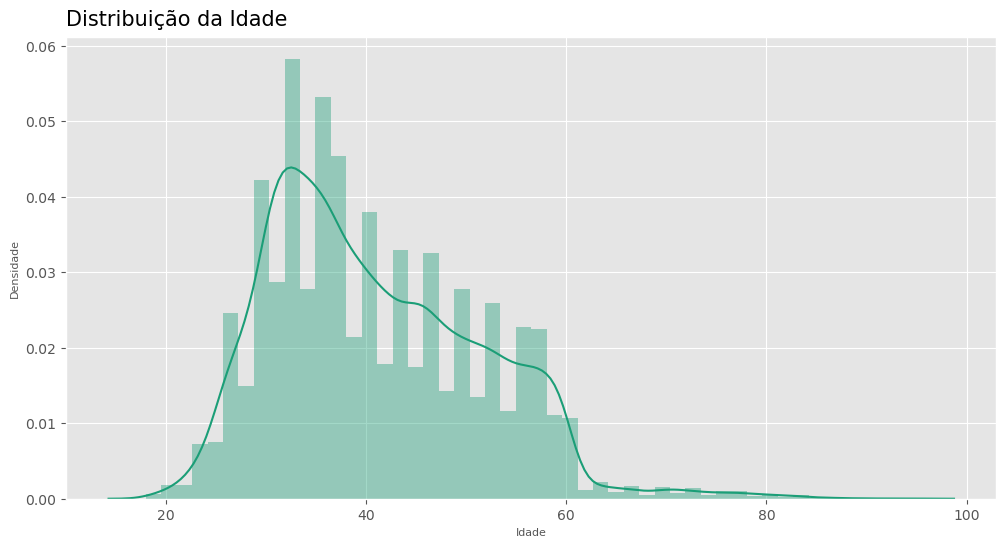

In [10]:
fig, ax = plt.subplots(figsize = (12,6))

sns.distplot(df.age)
ax.set_title("Distribuição da Idade", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Idade", fontsize = 8)
ax.set_ylabel("Densidade", fontsize = 8)
plt.show()

In [11]:
print(f"A idade média dos clientes é de: {df['age'].mean()}")
print(f"A idade mediana dos clientes é de: {df['age'].median()}")
print(f"O desvio padrão da idade média clientes é de: {df['age'].std()}")

A idade média dos clientes é de: 40.93621021432837
A idade mediana dos clientes é de: 39.0
O desvio padrão da idade média clientes é de: 10.618762040975431


Existe um assimetria na distribuição da idade causada pela quantidade de clientes na terceira idade.

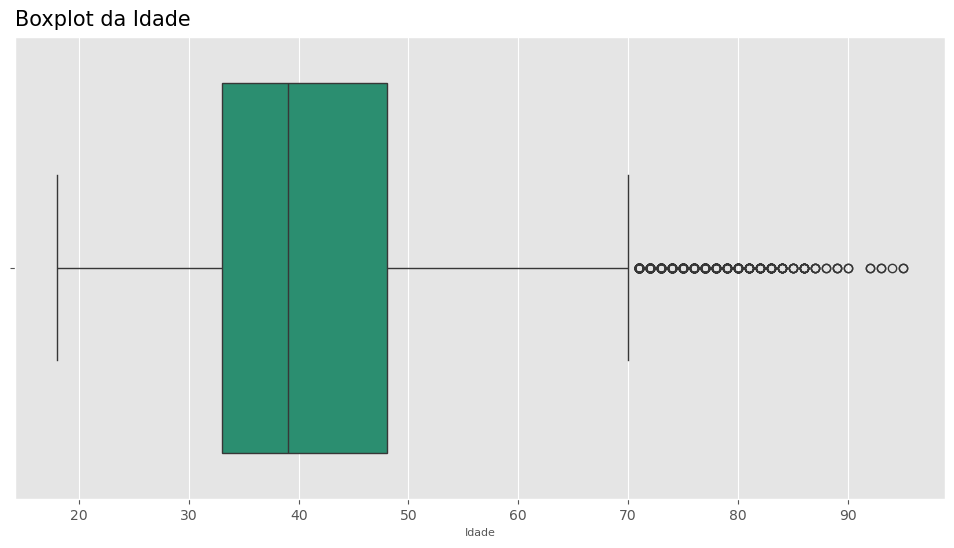

In [12]:
fig, ax = plt.subplots(figsize = (12,6))

sns.boxplot(df.age, orient = 'h')
ax.set_title("Boxplot da Idade", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Idade", fontsize = 8)
plt.show()

In [13]:
# Vamos checar quantos clientes acima dos 70 anos temos

filtro = df[df['age'] > 70].index
idosos = df.loc[filtro, 'age'].count()

print(f"O número de clientes acima dos 60 anos é {idosos}, eles são {round(((idosos / df.shape[0]) * 100), 2)}% do total.")

O número de clientes acima dos 60 anos é 487, eles são 1.08% do total.


A maioria dos clientes estão entre o meio de seus 30 anos e fim dos 40. Existe uma quantidade relavativamente baixa de idosos em relação ao restante. 

### Emprego

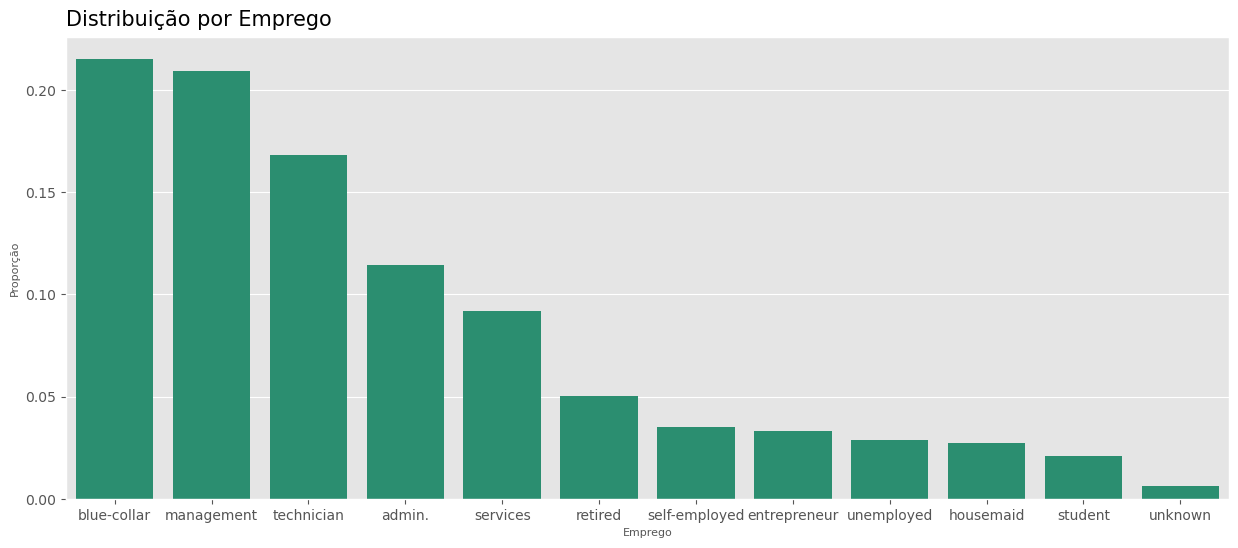

In [14]:
job_freq = df.job.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(job_freq, x = 'job', y = 'proportion')
ax.set_title("Distribuição por Emprego", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Emprego", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
plt.show()

No inglês "Blue-collar" se refere a empregos mais braçais, geralmente ligados a construção civil e prestação de serviços como operadores de máquinas, caminhoneiros, eletricistas e etc. Estes profissionais mais de 20% dos clientes do banco, seguidos por pessoas em cargos de gerência e técnicos. 

### Estado civil

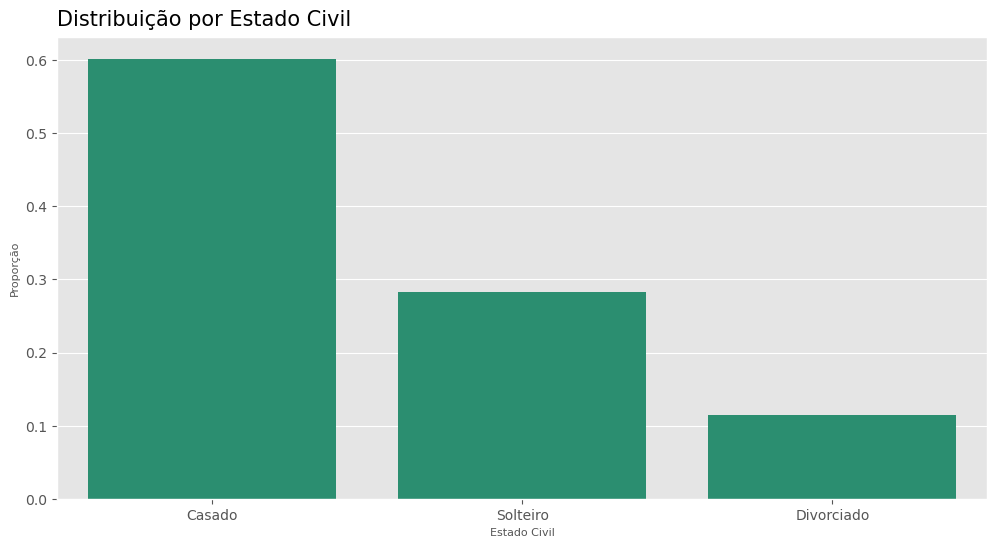

In [15]:
marital_freq = df.marital.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(marital_freq, x = 'marital', y = 'proportion')
ax.set_title("Distribuição por Estado Civil", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Estado Civil", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
ax.set_xticklabels(['Casado', 'Solteiro', 'Divorciado'])
plt.show()

### Educação

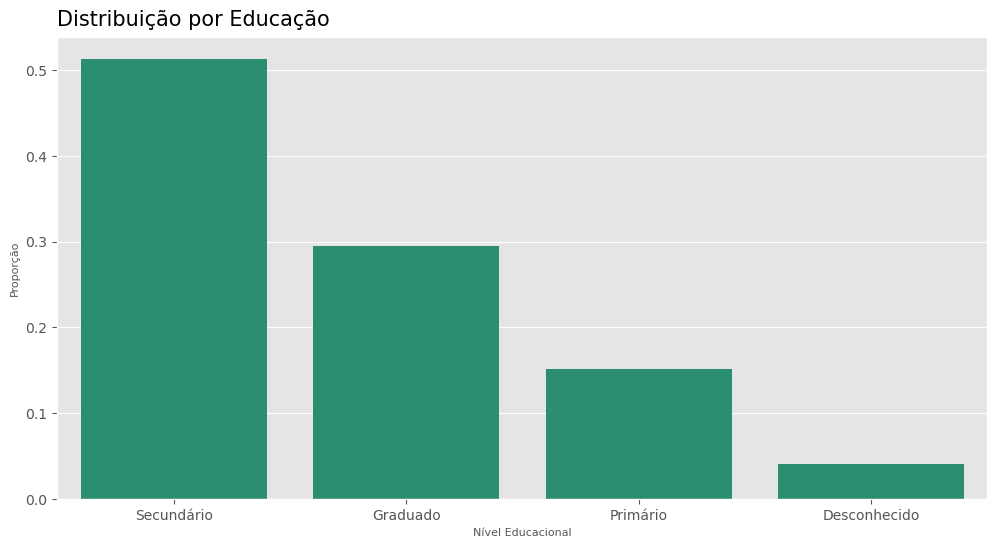

In [16]:
ed_freq = df.education.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(ed_freq, x = 'education', y = 'proportion')
ax.set_title("Distribuição por Educação", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Nível Educacional", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
ax.set_xticklabels(['Secundário', 'Graduado', 'Primário', 'Desconhecido'])
plt.show()

Quase 70% dos clientes do banco não possuem uma graduação, o que se reflete na alta quantidade de prestadores de serviços e técnicos entre eles. 

### Inadimplência

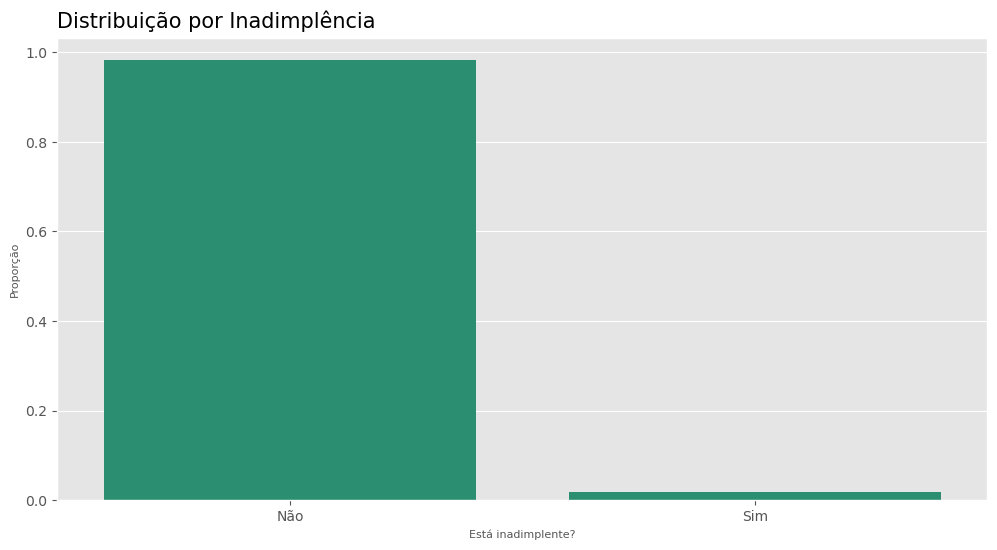

In [17]:
default_freq = df.default.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(default_freq, x = 'default', y = 'proportion')
ax.set_title("Distribuição por Inadimplência", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Está inadimplente?", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

### Balanço anual

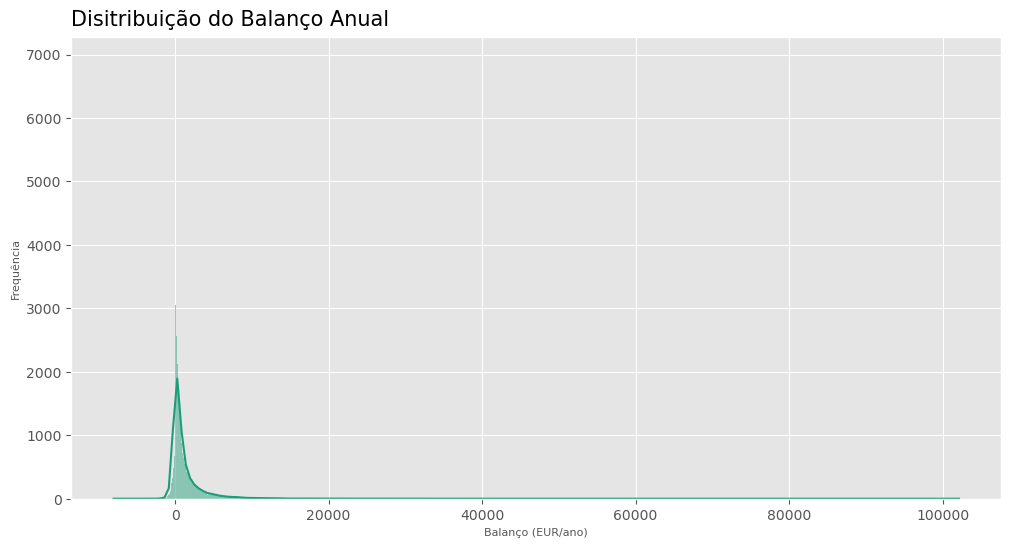

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.balance, kde = True)
ax.set_title("Disitribuição do Balanço Anual", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Balanço (EUR/ano)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

Como se tratam de dados bancários, é normal a existente de inviduos com saldos e balanços em valores muito maiores que a média.

### Financiamento imobiliário

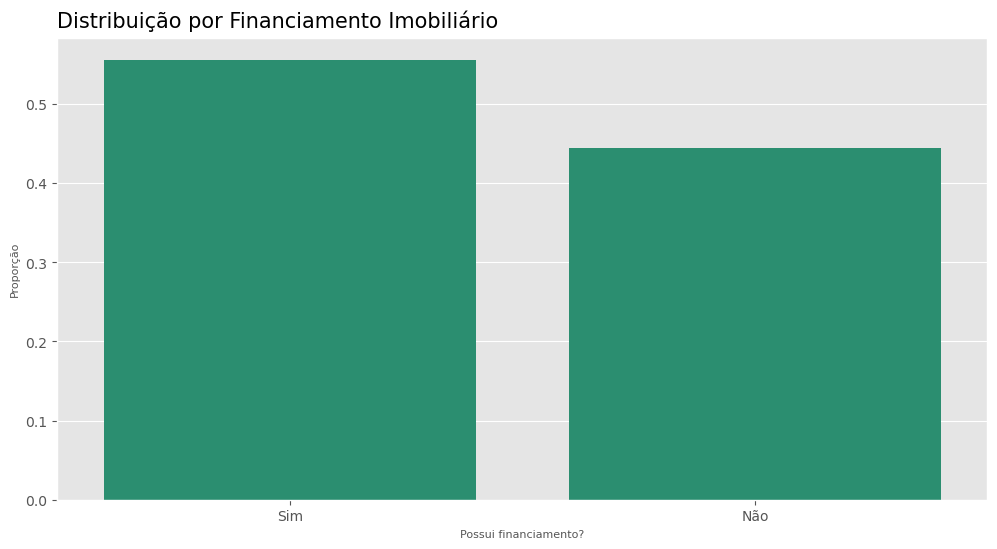

In [19]:
housing_freq = df.housing.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(housing_freq, x = 'housing', y = 'proportion')
ax.set_title('Distribuição por Financiamento Imobiliário', fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel('Possui financiamento?', fontsize = 8)
ax.set_ylabel('Proporção', fontsize = 8)
ax.set_xticklabels(['Sim', 'Não'])
plt.show()

### Empréstimo pessoal

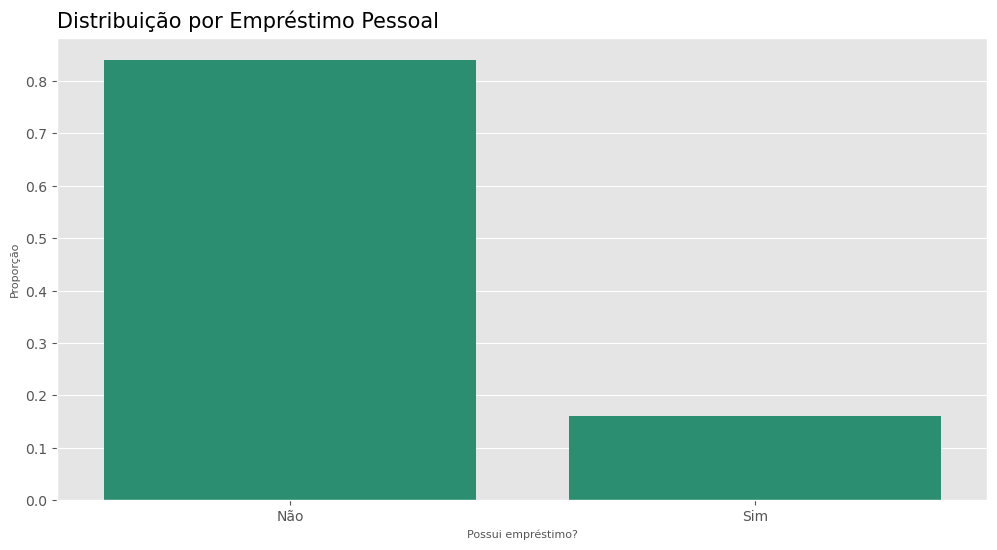

In [20]:
loan_freq = df.loan.value_counts(normalize=True).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(loan_freq, x = 'loan', y = 'proportion')
ax.set_title('Distribuição por Empréstimo Pessoal', fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel('Possui empréstimo?', fontsize = 8)
ax.set_ylabel('Proporção', fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

### Meio de contato

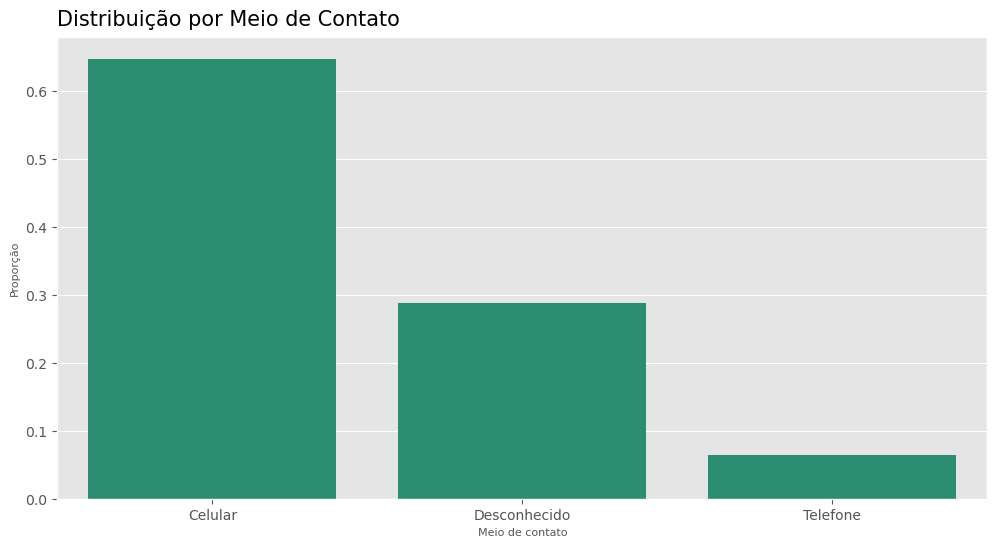

In [21]:
cont_freq = df.contact.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(cont_freq, x = 'contact', y = 'proportion')
ax.set_title('Distribuição por Meio de Contato', fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel('Meio de contato', fontsize = 8)
ax.set_ylabel('Proporção', fontsize = 8)
ax.set_xticklabels(['Celular', 'Desconhecido', 'Telefone'])
plt.show()

### Mês de contato

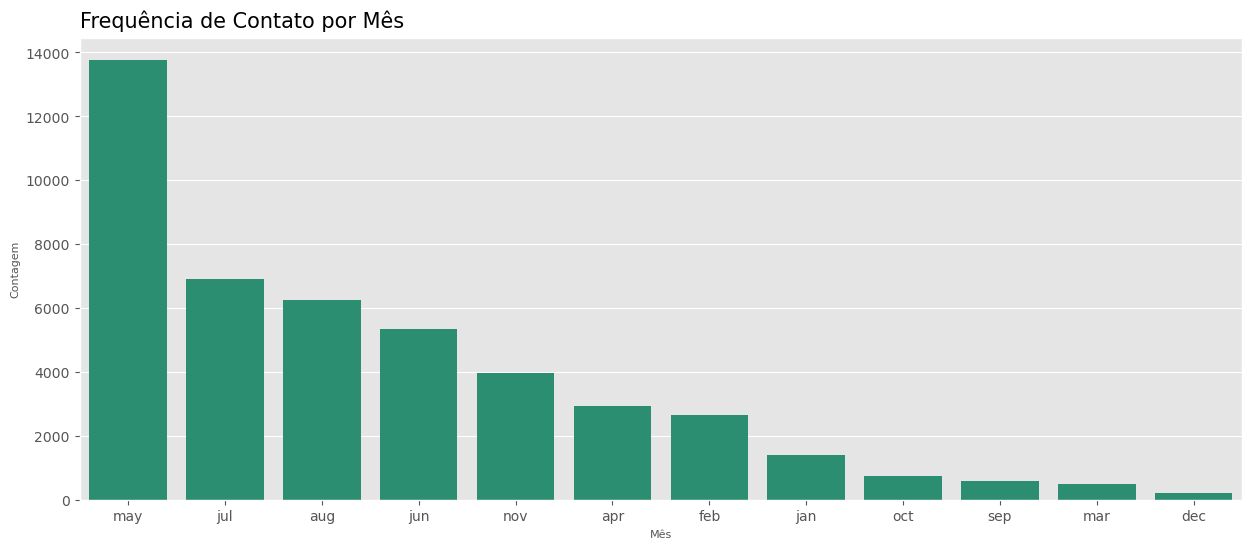

In [22]:
freq_month = df.month.value_counts().reset_index()

fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(freq_month, x = 'month', y = 'count')
ax.set_title('Frequência de Contato por Mês', fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel('Mês', fontsize = 8)
ax.set_ylabel('Contagem', fontsize = 8)
plt.show()

O volume de contatos se acumula entre o fim do segundo trimestre o começo do segundo, sendo maio o mês com maior quantidade de contatos.

### Duração das ligações

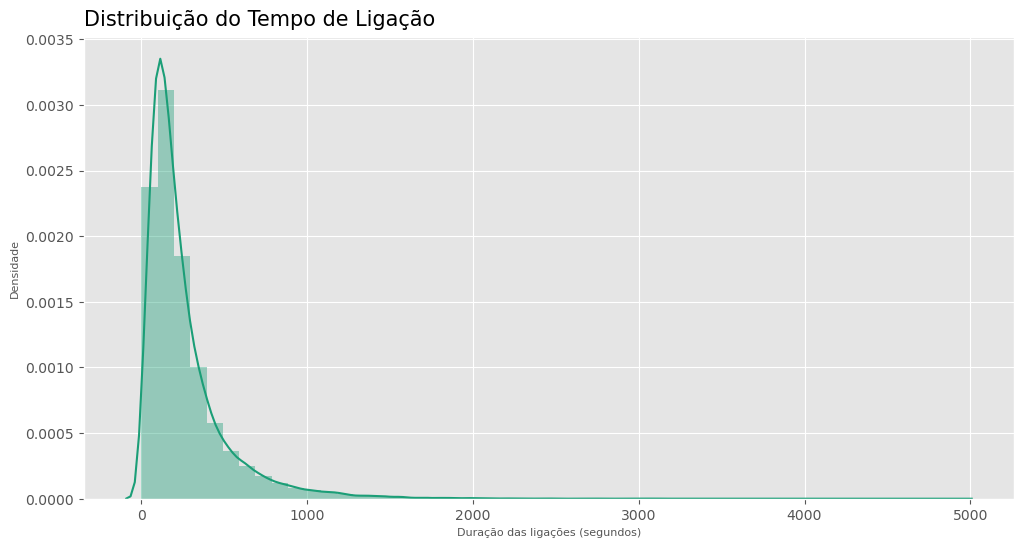

In [23]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.distplot(df.duration)
ax.set_title("Distribuição do Tempo de Ligação", fontsize=15, pad=8, loc='left')
ax.set_xlabel("Duração das ligações (segundos)", fontsize = 8)
ax.set_ylabel("Densidade", fontsize = 8)
plt.show()

In [24]:
print(f"A duração média das ligações é: {df.duration.mean()}")
print(f"A mediana da duração das ligações é: {df.duration.median()}")
print(f"O desvio padrão da duração das ligações é: {df.duration.std()}")

A duração média das ligações é: 258.1630797814691
A mediana da duração das ligações é: 180.0
O desvio padrão da duração das ligações é: 257.52781226517095


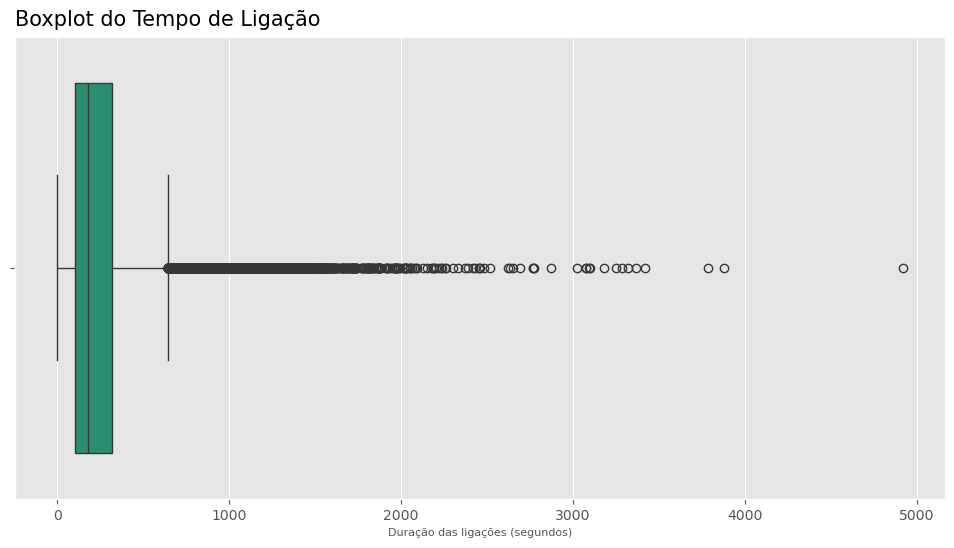

In [25]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(df.duration, orient = 'h')
ax.set_title("Boxplot do Tempo de Ligação", fontsize=15, pad=8, loc='left')
ax.set_xlabel("Duração das ligações (segundos)", fontsize = 8)
plt.show()

Existe uma alta quantidade de outliers nas ligações, outra variável que precisa de uma limpeza prévia, uma ligação de 1000 segundos tem aproximadamente 16 minutos é um tempo longo de ligação. Em breve vamos ver a relação entre o tempo de ligação e o sucesso na assintura do *term deposit*.

### Contatos durante a campanha

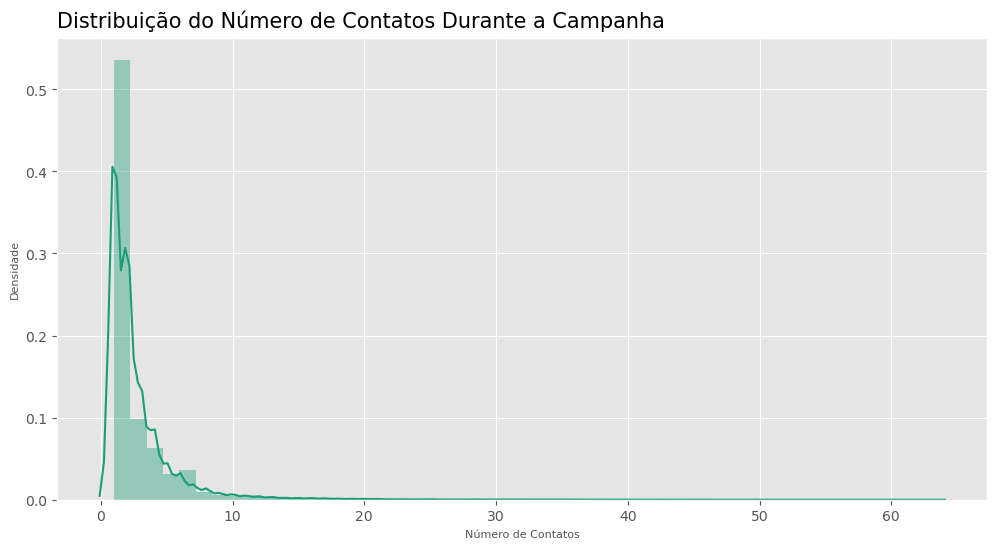

In [26]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.distplot(df.campaign)
ax.set_title("Distribuição do Número de Contatos Durante a Campanha", fontsize=15, pad=8, loc='left')
ax.set_xlabel("Número de Contatos", fontsize = 8)
ax.set_ylabel("Densidade", fontsize = 8)
plt.show()

In [27]:
print(f"Média de ligações durante a campanha: {df.campaign.mean()}")
print(f"Mediana de ligações durante a campanha: {df.campaign.median()}")
print(f"Desvio padrão do número de ligações: {df.campaign.std()}")

Média de ligações durante a campanha: 2.763840658246887
Mediana de ligações durante a campanha: 2.0
Desvio padrão do número de ligações: 3.0980208832802205


Essa é outra variável que sofre com outliers, e é um ponto de alerta, um cliente que recebe mais de 50 ligações sobre uma campanha pode se tornar alguém em ponto de churn ou um processo legal contra instituição. 

### Dias entre contato sobre a última campanha e a atual

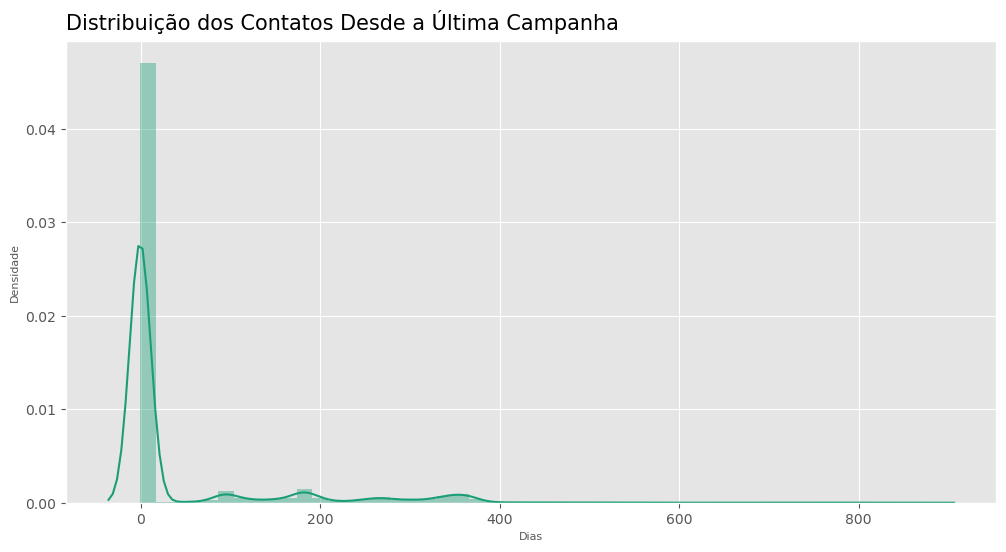

In [28]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.distplot(df.pdays)
ax.set_title("Distribuição dos Contatos Desde a Última Campanha", fontsize=15, pad=8, loc='left')
ax.set_xlabel("Dias", fontsize = 8)
ax.set_ylabel("Densidade", fontsize = 8)
plt.show()


Clientes que não foram contatados na última campanha são marcados com -1. Vamos ver a proporção da base que não foi contatada. 

In [29]:
filtro = df[df['pdays'] == -1].index
prop_sem_contato =(df.loc[filtro].shape[0] / df.shape[0]) * 100
print(f"A porcentagem de clientes que não foram contatados em campanhas anteriores: {round(prop_sem_contato, 2)}%")

A porcentagem de clientes que não foram contatados em campanhas anteriores: 81.74%


Acredito que a variável de número de contatos seja mais representativa que a de número de dias. A um volume alto de clientes não contatados, vamos ver se isso se confirma na variável de número de contatos.

### Contatos antes da campanha atual

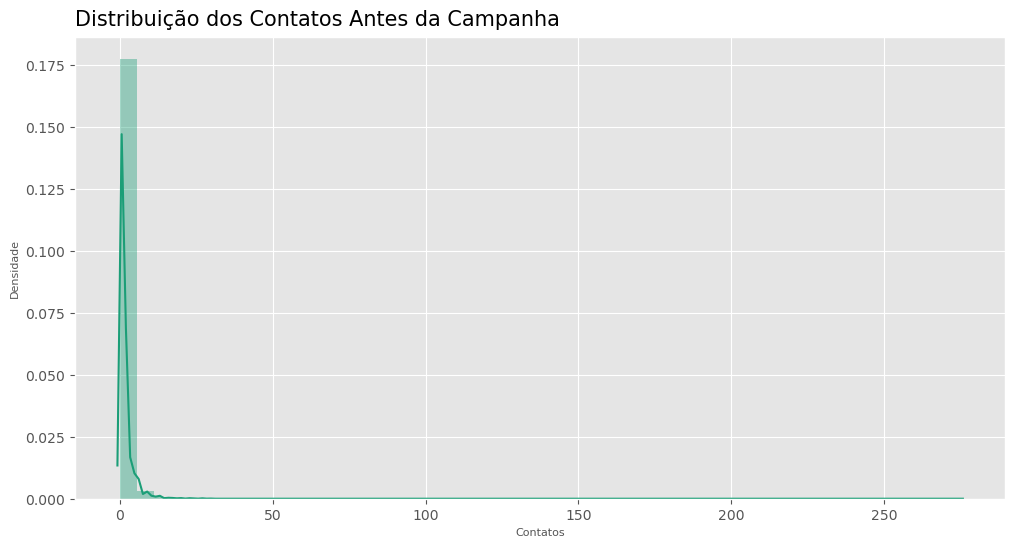

In [30]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.distplot(df.previous)
ax.set_title("Distribuição dos Contatos Antes da Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Contatos", fontsize = 8)
ax.set_ylabel("Densidade", fontsize = 8)
plt.show()

In [31]:
filtro = df[df['previous'] == 0].index
prop_sem_contato =(df.loc[filtro].shape[0] / df.shape[0]) * 100
print("Considerando o número de contatos")
print(f"A porcentagem de clientes que não foram contatados em campanhas anteriores: {round(prop_sem_contato, 2)}%")

Considerando o número de contatos
A porcentagem de clientes que não foram contatados em campanhas anteriores: 81.74%


Vou preferir para o modelo de Machine Learning usar essa feature, e remover a anterior. Existe um alto volume de cliente não contatados, o que também mostra espaço de ação livre para oferta de produtos bancários. 

### Resultado em campanhas anteriores

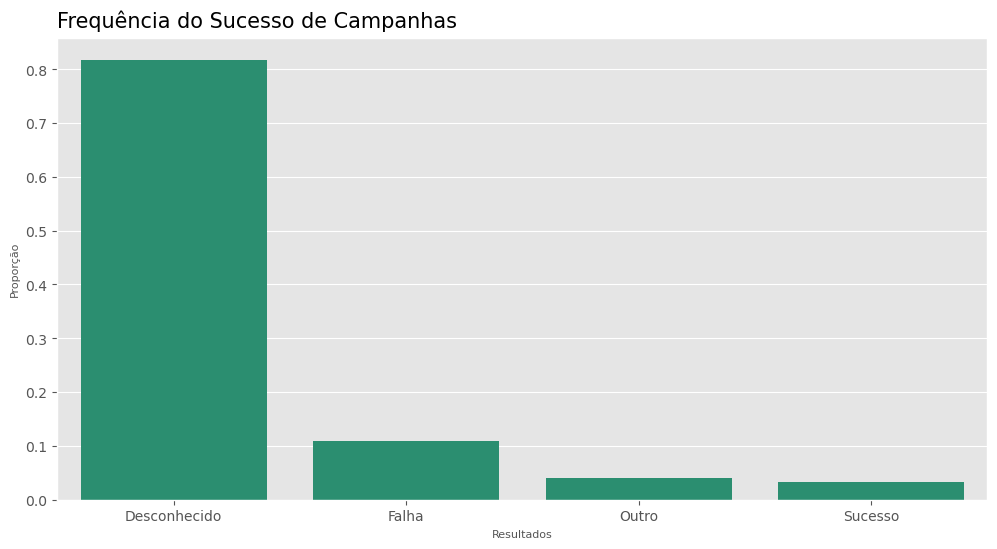

In [32]:
freq_outcome = df.poutcome.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(freq_outcome, x = 'poutcome', y = 'proportion')
ax.set_title("Frequência do Sucesso de Campanhas", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Resultados", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
ax.set_xticklabels(['Desconhecido', 'Falha', 'Outro', 'Sucesso'])
plt.show()

### Sucesso na campanha atual

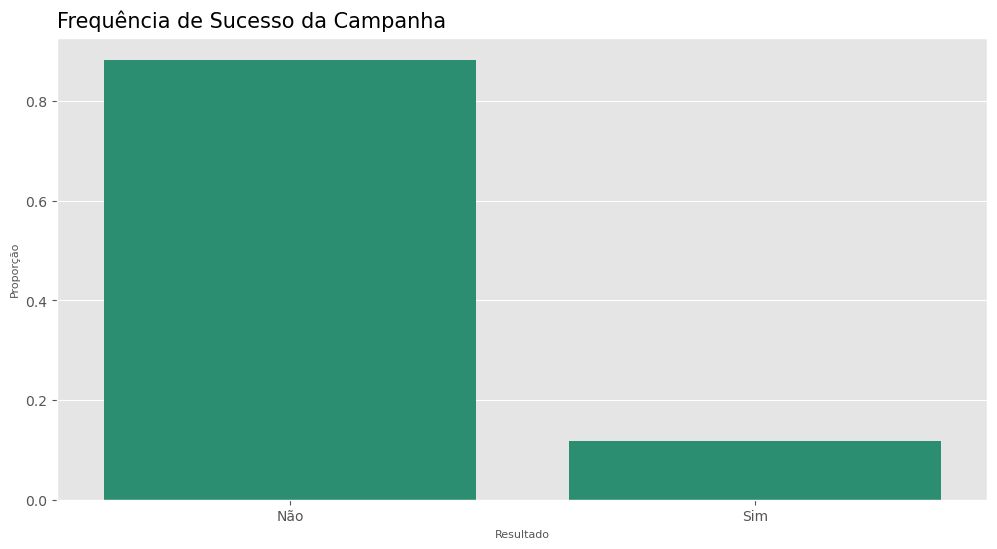

In [33]:
freq_y = df.y.value_counts(normalize = True).reset_index()

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(freq_y, x = 'y', y = 'proportion')
ax.set_title("Frequência de Sucesso da Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Resultado", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

A campanha tem uma taxa de sucesso de somente 11%. 

## 4.3. Features x Target

### Idade x Sucesso da Campanha

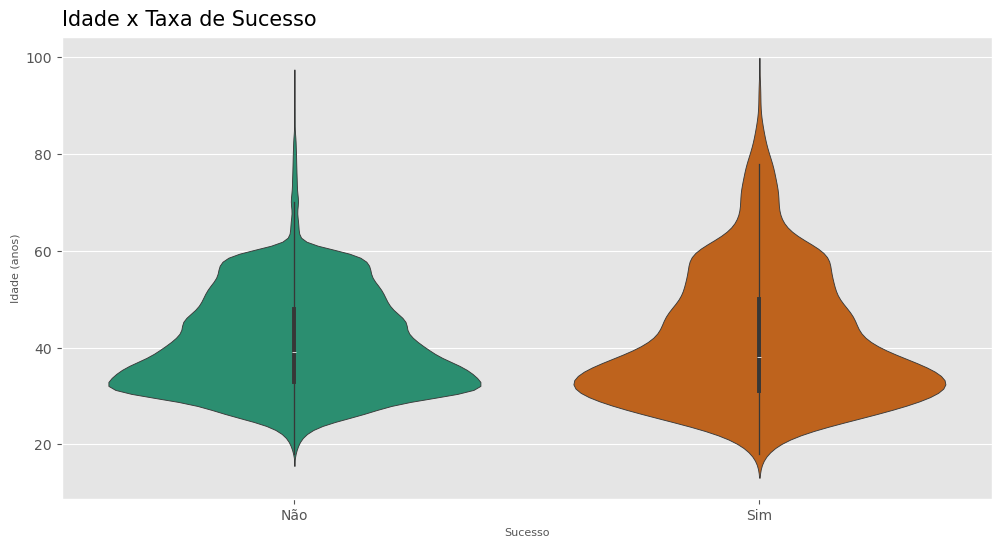

In [34]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df.y, y = df.age, hue = df.y)
ax.set_title("Idade x Taxa de Sucesso", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Idade (anos)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

Existe uma tendência no aceite do *term deposit* em clientes mais velhos.

### Profissão x Sucesso da Campanha

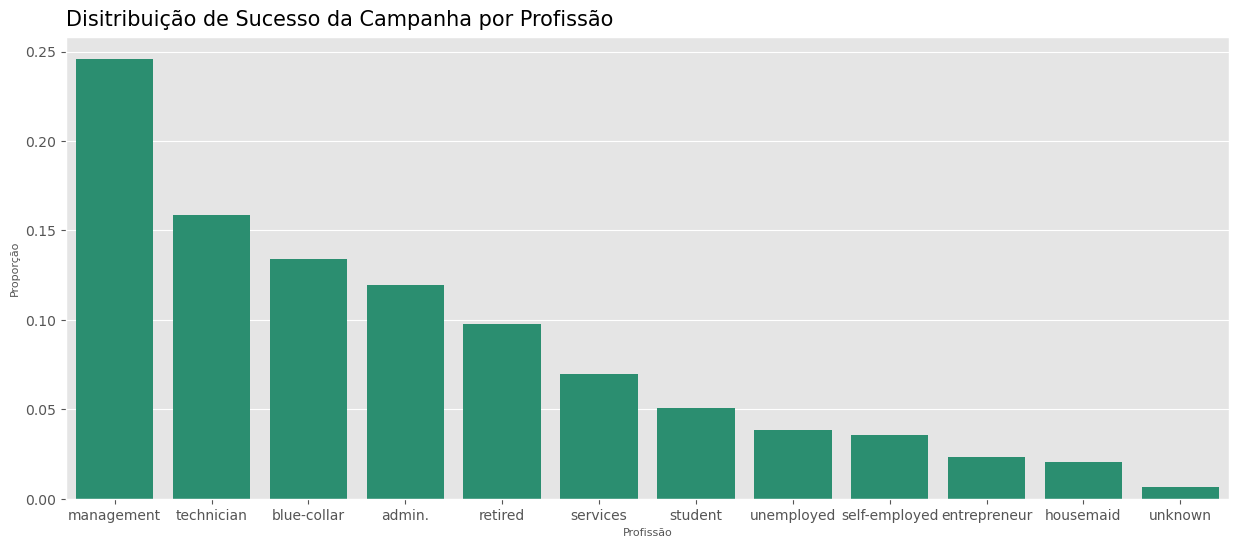

In [35]:
filtro = df[df['y'] == 'yes'].index
success_job = df.loc[filtro, 'job'].value_counts(normalize = True)

fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = success_job.index, y = success_job.values)
ax.set_title("Disitribuição de Sucesso da Campanha por Profissão", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Profissão", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
plt.show()

Com segundo maior número de clientes dentro do banco, pessoas em cargos de gerência tem maior sucetividade a aceitar o *term deposit*, seguidos por técnicos e prestadores de serviços. É interessante buscar estes profissionais para oferta também de outros produtos. 

### Estado Civil x Sucesso da Campanha

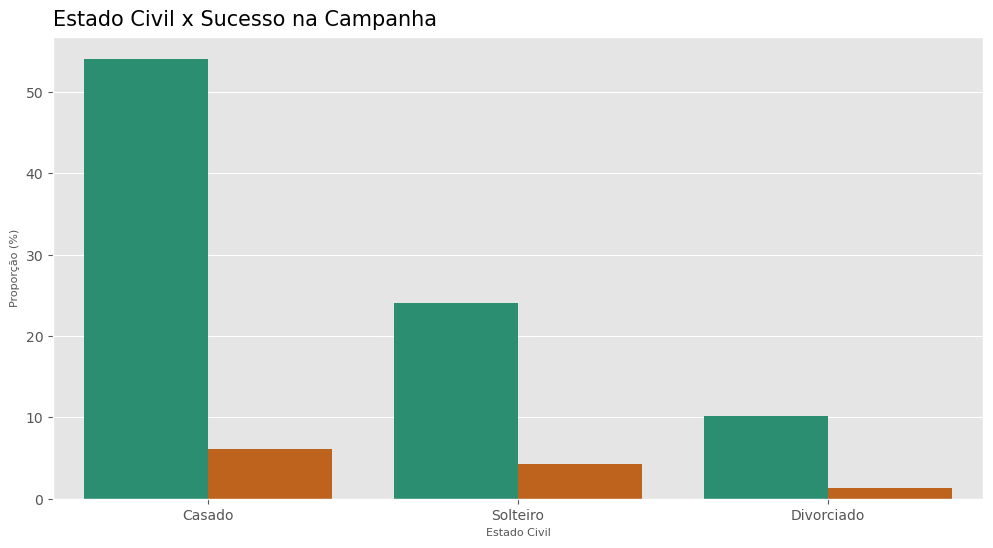

In [36]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.marital, hue = df.y, stat = 'percent')
ax.set_title("Estado Civil x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Estado Civil", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Casado', 'Solteiro', 'Divorciado'])
ax.legend().remove()
plt.show()

### Nível de Educação x Sucesso da Campanha

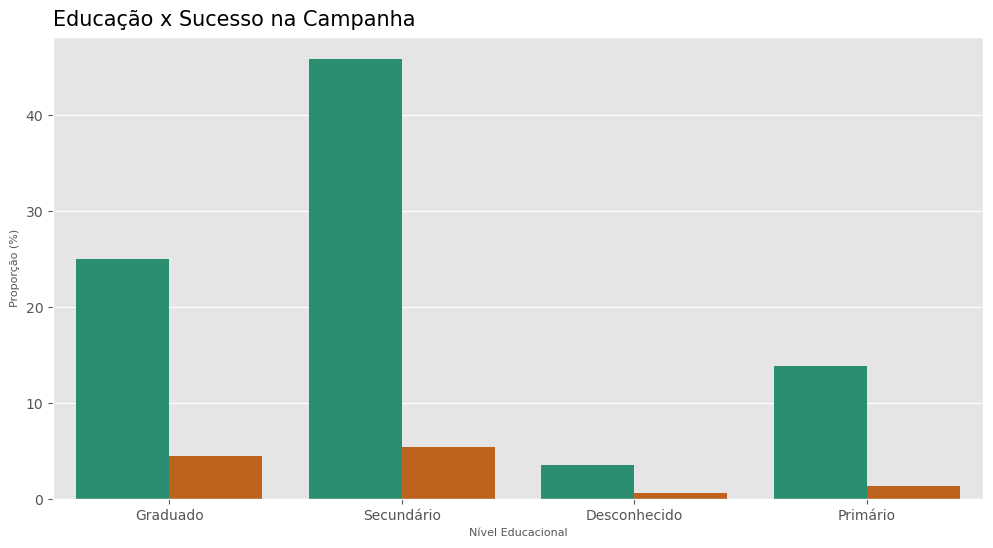

In [37]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.education, hue = df.y, stat = 'percent')
ax.set_title("Educação x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Nível Educacional", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Graduado', 'Secundário', 'Desconhecido', 'Primário'])
ax.legend().remove()
plt.show()

### Inadimplência x Sucesso na Campanha

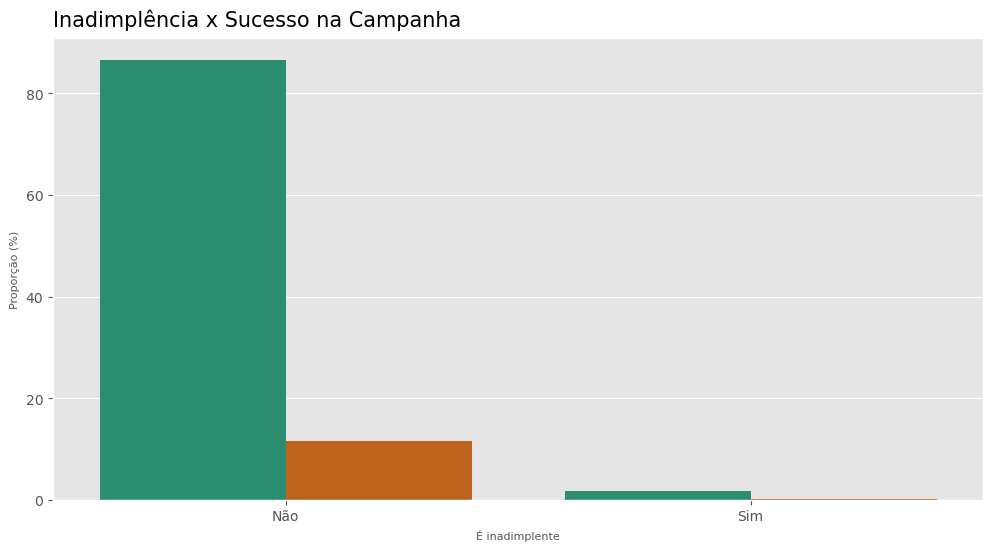

In [38]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.default, hue = df.y, stat = 'percent')
ax.set_title("Inadimplência x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("É inadimplente", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
ax.legend().remove()
plt.show()

### Balanço Anual x Sucesso da Campanha

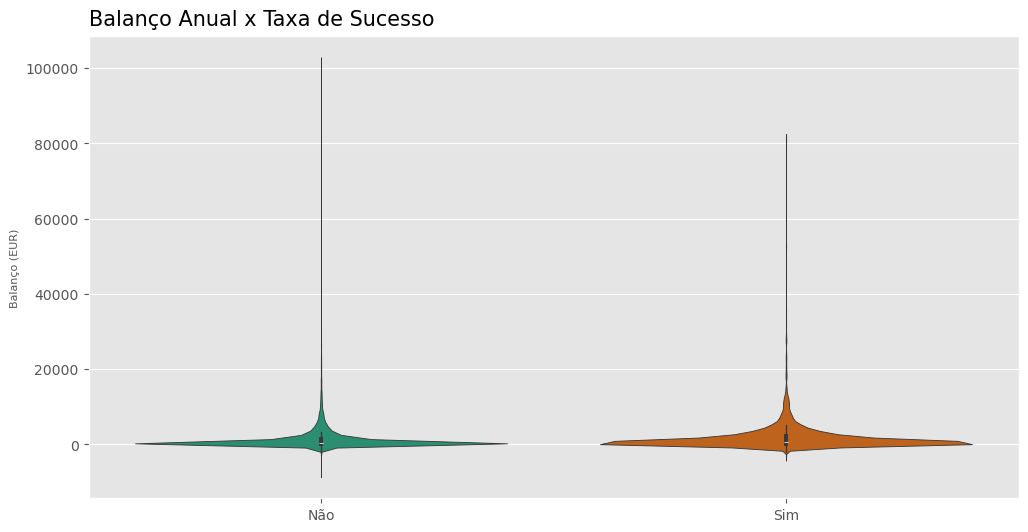

In [39]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df.y, y = df.balance, hue = df.y)
ax.set_title("Balanço Anual x Taxa de Sucesso", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("Balanço (EUR)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

Os outliers dificultam um pouco a visualização, vamos realizar a remoção dos outliers para checar a distribuição. 

In [40]:
df_clean = df.copy()
z_scores_balance = np.abs(zscore(df[['balance']]))
df_clean = df[(z_scores_balance < 3).all(axis = 1)]
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


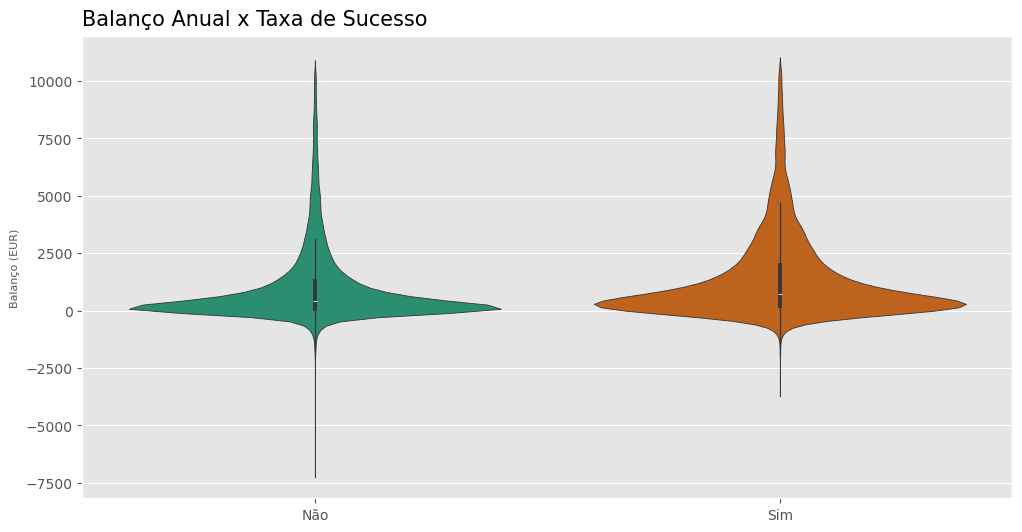

In [41]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df_clean.y, y = df_clean.balance, hue = df_clean.y)
ax.set_title("Balanço Anual x Taxa de Sucesso", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("Balanço (EUR)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

Assim podemos confirmar a baixa relação entre balanço anual, e o sucesso da campanha.

### Meio de Contato x Sucesso da Campanha

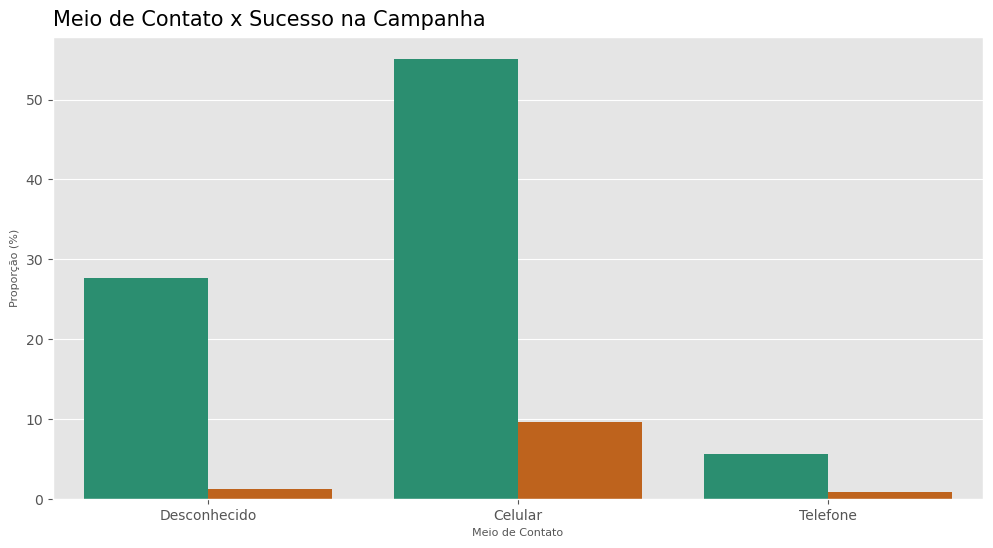

In [42]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.contact, hue = df.y, stat = 'percent')
ax.set_title("Meio de Contato x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Meio de Contato", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Desconhecido', 'Celular', 'Telefone'])
ax.legend().remove()
plt.show()

### Mês x Sucesso da Campanha

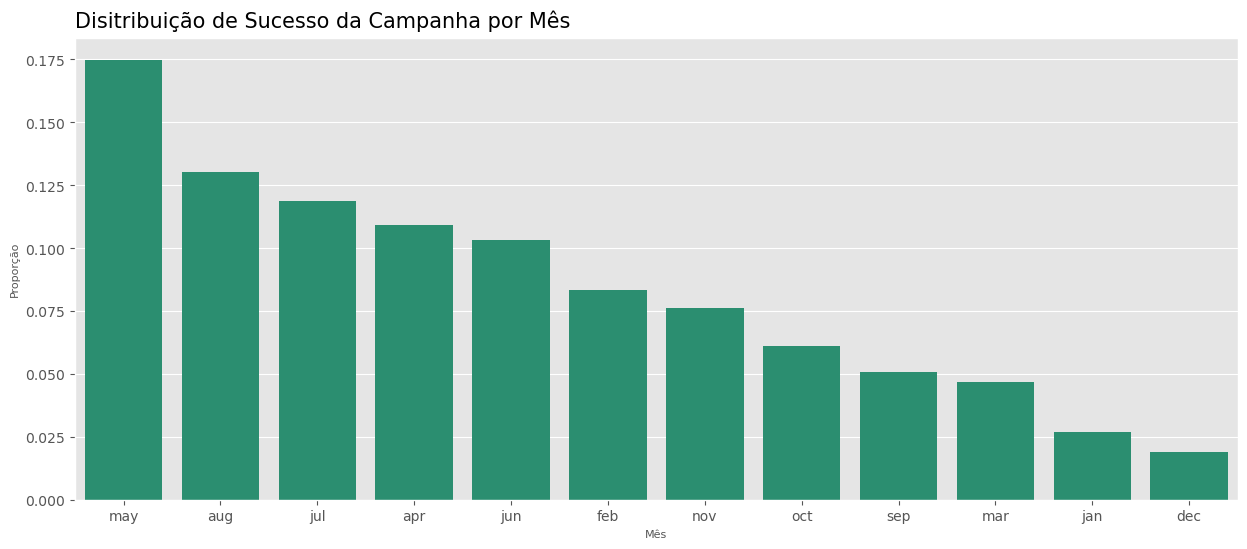

In [43]:
filtro = df[df['y'] == 'yes'].index
success_month = df.loc[filtro, 'month'].value_counts(normalize = True)

fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = success_month.index, y = success_month.values)
ax.set_title("Disitribuição de Sucesso da Campanha por Mês", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Mês", fontsize = 8)
ax.set_ylabel("Proporção", fontsize = 8)
plt.show()

O segundo e o terceiro trimestre são os períodos de maior sucesso nas campanhas, e podem ser trabalhadas campanhas com um orçamento maior nestes meses. Em especial Maio-Abril e Julho-Agosto. 

### Duração das Ligações x Sucesso da Campanha

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


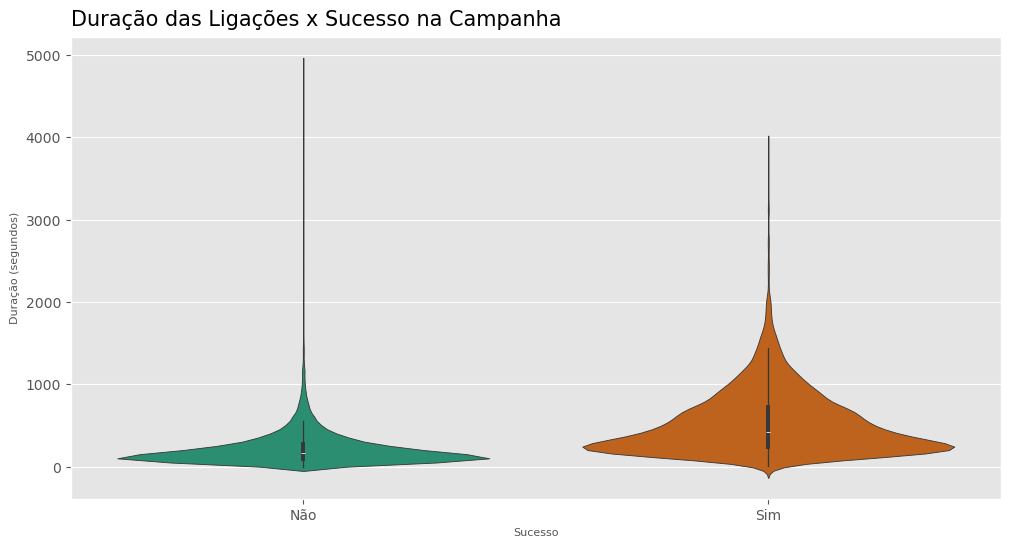

In [44]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df.y, y = df.duration, hue = df.y)
ax.set_title("Duração das Ligações x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Duração (segundos)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
ax.legend().remove()
plt.show()

Ligações mais longas tem maior chance de sucesso, mas o quão longas?

In [45]:
# Primeiro vou remover outliers

df_clean = df.copy()
z_scores_duration = np.abs(zscore(df[['duration']]))
df_clean = df[(z_scores_duration < 3).all(axis = 1)]

In [46]:
filtro = df_clean[df_clean['y'] == 'yes'].index
duration = df_clean.loc[filtro, 'duration']

print(f"A duração média de uma ligação com sucesso: {round((duration.mean() / 60), 2)} minutos")
print(f"A duração mínima de uma ligação com sucesso: {round((duration.min() / 60), 2)} minutos")
print(f"A duração mínima de uma ligação com sucesso: {round((duration.max() / 60), 2)} minutos")

A duração média de uma ligação com sucesso: 7.25 minutos
A duração mínima de uma ligação com sucesso: 0.13 minutos
A duração mínima de uma ligação com sucesso: 17.17 minutos


A média de 7 minutos pode se tornar uma métrica para o treinamento dos colabodores de telemarketing. 

### Financiamento Imobiliário x Sucesso na Campanha

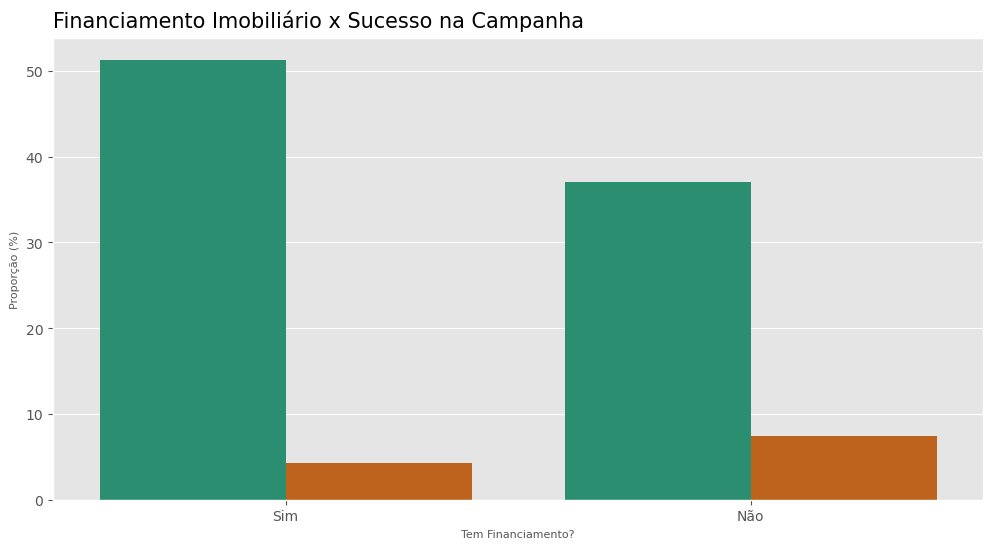

In [47]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.housing, hue = df.y, stat = 'percent')
ax.set_title("Financiamento Imobiliário x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Tem Financiamento?", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Sim', 'Não'])
ax.legend().remove()
plt.show()

Pessoas sem financiamento imobiliário tem mais espaço para novos investimentos. 

### Emprestimo Pessoal x Sucesso na Campanha

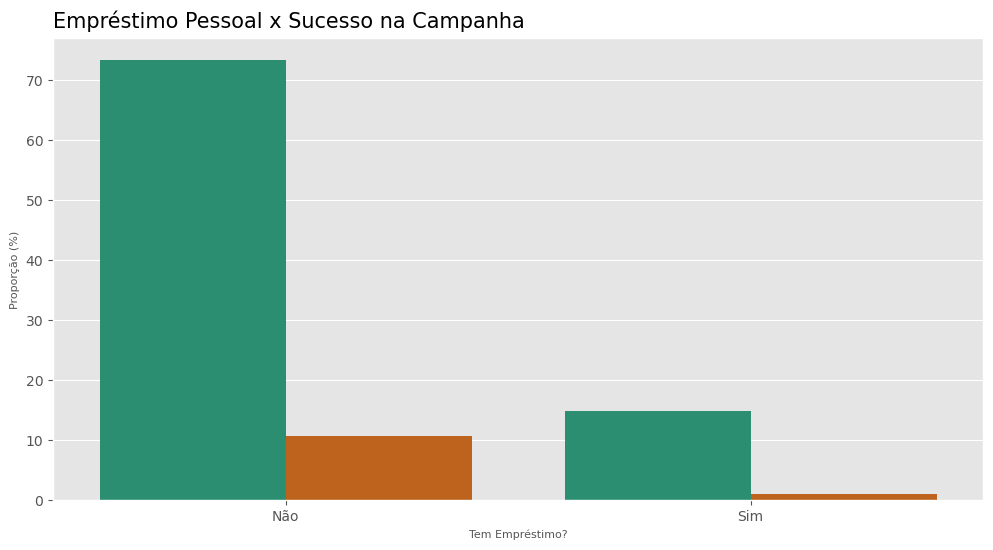

In [48]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.loan, hue = df.y, stat = 'percent')
ax.set_title("Empréstimo Pessoal x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Tem Empréstimo?", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
ax.legend().remove()
plt.show()

### Contatos x Sucesso da Campanha

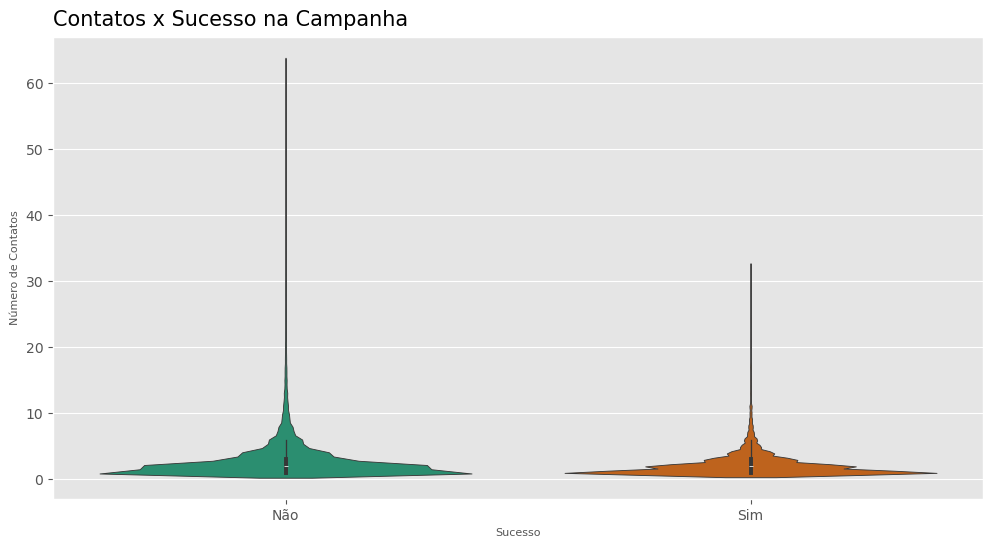

In [49]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df.y, y = df.campaign, hue = df.y)
ax.set_title("Contatos x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Número de Contatos", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

Novamente os outliers dificultam um pouco a interpretação, vamos observar sem eles. 

In [50]:
df_clean = df.copy()
z_scores_campaign = np.abs(zscore(df[['campaign']]))
df_clean = df[(z_scores_campaign < 3).all(axis = 1)]

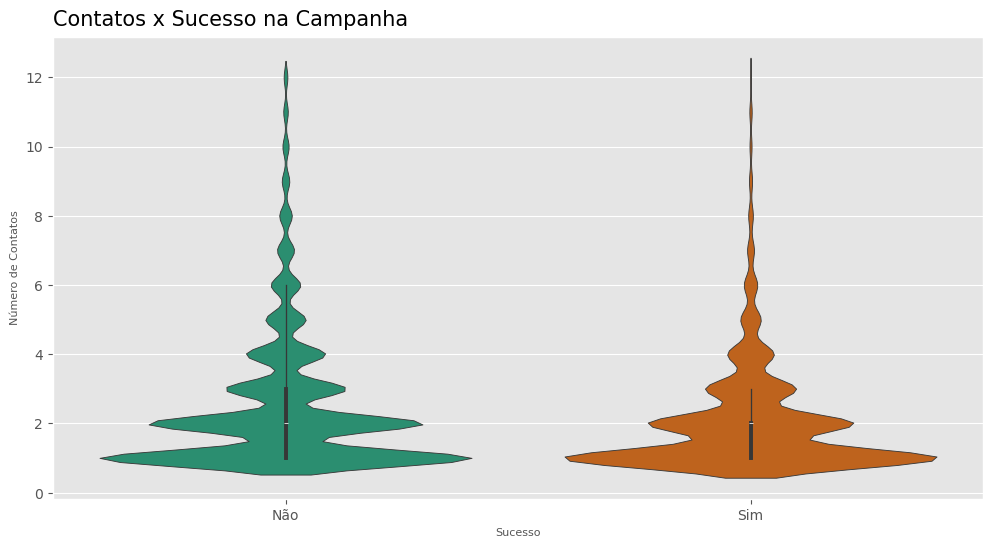

In [51]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df_clean.y, y = df_clean.campaign, hue = df_clean.y)
ax.set_title("Contatos x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Número de Contatos", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

In [52]:
filtro = df_clean[df_clean['y'] == 'yes'].index
campaign = df_clean.loc[filtro, 'campaign']

print(f"Número médio de ligações para um resultado positivo: {campaign.mean()}.")
print(f"Número mínimo de ligações para um resultado positivo: {campaign.min()}.")
print(f"Número máximo de ligações para um resultado positivo: {campaign.max()}.")
print(f"Desvio padrão do número de ligações: {campaign.std()}")

Número médio de ligações para um resultado positivo: 2.065754465982516.
Número mínimo de ligações para um resultado positivo: 1.
Número máximo de ligações para um resultado positivo: 12.
Desvio padrão do número de ligações: 1.5776938358631944


Apesar do número máximo de ligações ser de 12, podemos usar como métrica uma quantidade de até 3 desvios padrões da média (como em uma distribuição normal) tornando 7 o máximo de ligações feitas a um cliente, podendo assim otimizar tempo e recursos do time de telemarketing. 

### Contatos Anteriores x Sucesso da Campanha

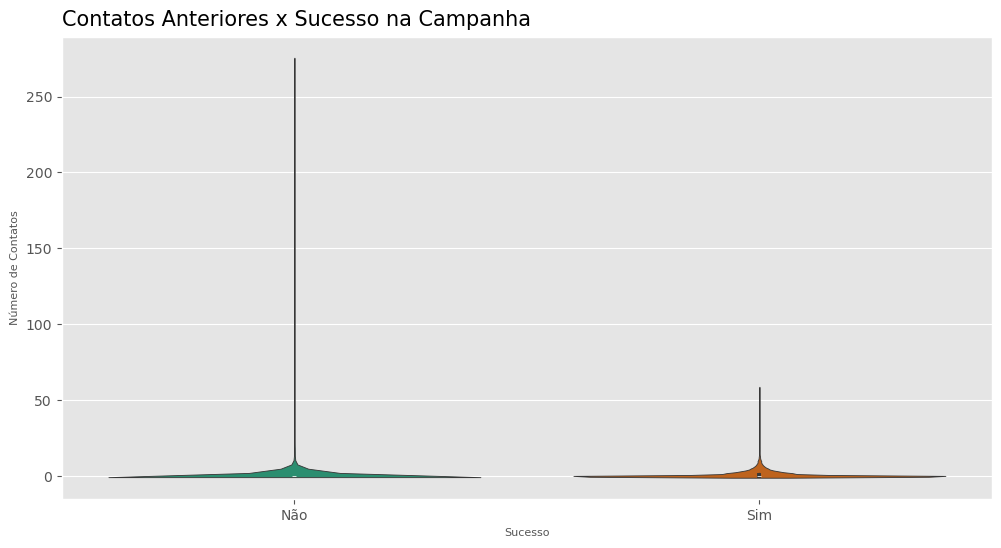

In [53]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df.y, y = df.previous, hue = df.y)
ax.set_title("Contatos Anteriores x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Número de Contatos", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

In [54]:
df_clean = df.copy()
z_scores_previous = np.abs(zscore(df[['previous']]))
df_clean = df[(z_scores_previous < 3).all(axis = 1)]

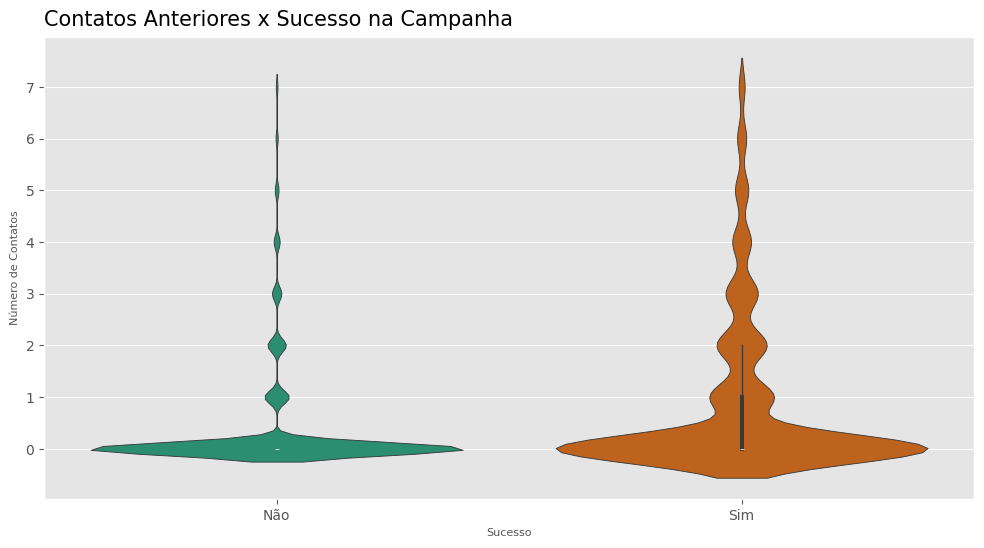

In [55]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(x = df_clean.y, y = df_clean.previous, hue = df_clean.y)
ax.set_title("Contatos Anteriores x Sucesso na Campanha", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Sucesso", fontsize = 8)
ax.set_ylabel("Número de Contatos", fontsize = 8)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

Pessoas com maior número de contatos em campanhas anteriores tem maiores chances de aceitar o *term deposit*.

### Sucesso em Campanhas Anteiores x Sucesso na Campanha Atual

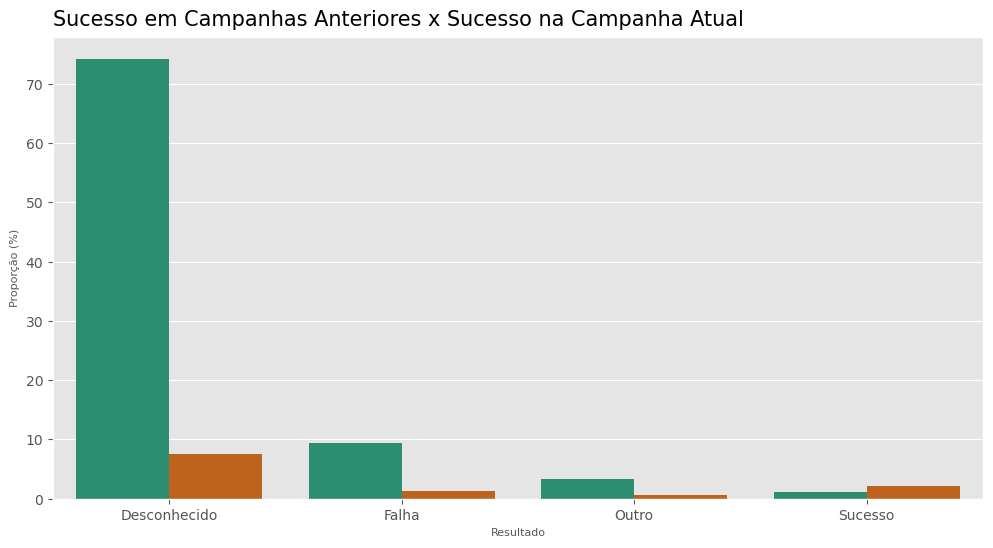

In [56]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df.poutcome, hue = df.y, stat = 'percent')
ax.set_title("Sucesso em Campanhas Anteriores x Sucesso na Campanha Atual", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Resultado", fontsize = 8)
ax.set_ylabel("Proporção (%)", fontsize = 8)
ax.set_xticklabels(['Desconhecido', 'Falha', 'Outro', 'Sucesso'])
ax.legend().remove()
plt.show()

## 3.4. Conclusões da EDA

- Clientes mais velhos tem maior probabilidade de aceite;
- Com segundo maior número de clientes dentro do banco, pessoas em cargos de gerência tem maior sucetividade a aceitar o *term deposit*, seguidos por técnicos e prestadores de serviços. Campanhas segmentadas a categórias profissionais podem trazer um bom resultado.
- Clientes adimplentes e sem crédito comprometido com empréstimos imobiliários ou pessoais tem maior probabilidade de aceitar os produtos, é interessante focar nestes clientes nas campanhas;
- O meio de contato mais efetivo é o celular;
- O segundo e o terceiro trimestre são os períodos de maior sucesso nas campanhas, e podem ser trabalhadas campanhas com um orçamento maior nestes meses. Em especial Maio-Abril e Julho-Agosto
- A média de tempo das ligações com resultado positivo é de 7,25 minutos, essa pode ser uma boa métrica para os colaboradores do telemarketing assim como o número de ligações que deve ser entre 2 e 7;
- Clientes com respostas positivas em campanhas anteriores tem tendência de aceitar ofertas em novas campanhas. 

Portanto sugiro para as próximas campanhas:
1. Iniciar por (1) clientes os contatos por clientes adimplentes e com crédito livre, (2) clientes que aceitaram o produtos na última campanha;
2. Realizar entre de 2 a 7 ligações, e só voltar a ligar para clientes que passaram deste limite quando os contatos a todos forem concluídos dentro deste limite;
3. Ao conseguir o contato, buscar alongar a ligação até no máximo 7 minutos, ao passar desse prazo de tempo as probabilidades de aceite diminuem;
4. Criar campanhas segmentadas por profissões e tentar colocar elas no espaço de tempo com maior probabilidade de sucesso, como o périodo Julho-Agosto por exemplo. 

# 4. Preparação dos Dados

## 4.1. Seleção das features

In [57]:
# Primeiro vou fazer a transformação da target

le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])

In [58]:
features = df.drop(columns = ['y', 'pdays'], axis = 1).columns.to_list()
target = 'y'

cat_features = df[features].select_dtypes(include = 'object').columns.to_list()
num_features = df[features].select_dtypes(include = 'number').columns.to_list()
print(f"Fatures categóricas: \n {cat_features}")
print(f"Features numéricas: \n {num_features}")

Fatures categóricas: 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Features numéricas: 
 ['age', 'balance', 'day', 'duration', 'campaign', 'previous']


## 4.2. Split em treino e teste

In [59]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=df[target], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Taxa de resposta em treino: {y_train.mean()}")
print(f"Taxa de resposta em teste: {y_test.mean()}")

(36168, 15) (9043, 15) (36168,) (9043,)
Taxa de resposta em treino: 0.11698186241981863
Taxa de resposta em teste: 0.11699657193409267


## 4.3. Definição das etapas de pré-processamento

In [60]:
cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('encoder', ce.OrdinalEncoder(cols=cat_features))
])

num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# 5. Modelo de Classificação 

## 5.1. Instanciamento do modelo

In [61]:
model = LGBMClassifier(learning_rate=0.05, n_estimators=100, num_leaves=31)

lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(cols=['job',
                                                                                        'marital',
                                                                                        'education',
                                                                                        'default',
                                                                                        'housing',
                                                                                        'loan',
                                                                                        'contact',
                                                                                        'month',
                                                                                        'poutcome']))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'previous'])])),
                ('model', LGBMClassifier(learning_rate=0.05))])

## 5.2. Previsões

In [62]:
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)[:,1]

In [63]:
y_pred_train = lgb.predict(X_train)
y_pred_proba_train = lgb.predict_proba(X_train)[:,1]

## 5.3. Métricas

In [64]:
def metrics_report(y_true, y_pred_proba, threshold = 0.5):
     y_pred = (y_pred_proba >= threshold).astype(int)

     loss = log_loss(y_true, y_pred_proba)
     acc = accuracy_score(y_true, y_pred)
     roc_auc = roc_auc_score(y_true, y_pred_proba)

     return {
         'Log Loss': loss,
         'Accuracy': acc,
         'ROC AUC': roc_auc,
     }

In [65]:
print("Report do Treino: ", metrics_report(y_train, y_pred_proba_train))

Report do Treino:  {'Log Loss': 0.1816845927261436, 'Accuracy': 0.9176896704268968, 'ROC AUC': 0.9487386894638727}


In [66]:
print("Report do Teste: ", metrics_report(y_test, y_pred_proba))

Report do Teste:  {'Log Loss': 0.2030973289164661, 'Accuracy': 0.9050093995355524, 'ROC AUC': 0.9290686814715208}


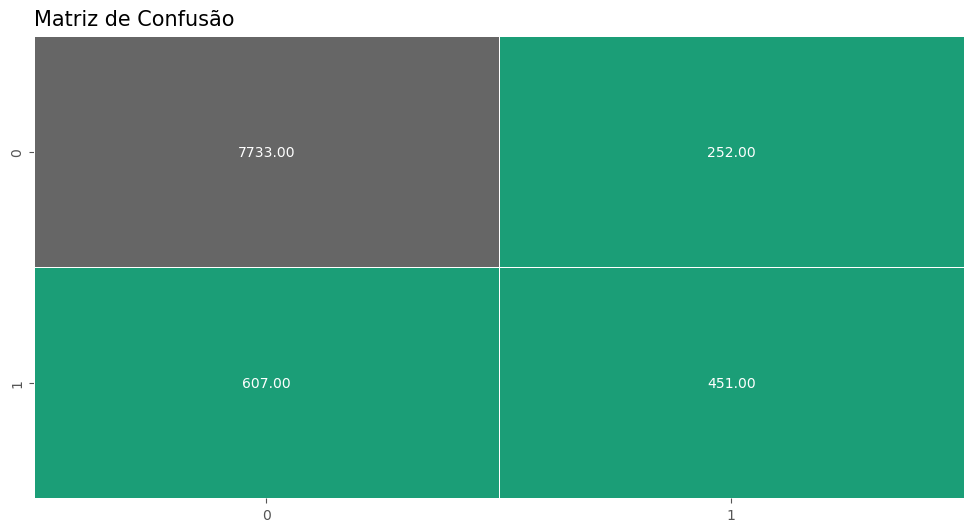

In [67]:
matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(matrix, annot = True, fmt = '.2f', linewidths=0.5, linecolor='white', cmap = 'Dark2',cbar=False)
ax.set_title("Matriz de Confusão", fontsize = 15, pad = 8, loc = 'left')
plt.show()


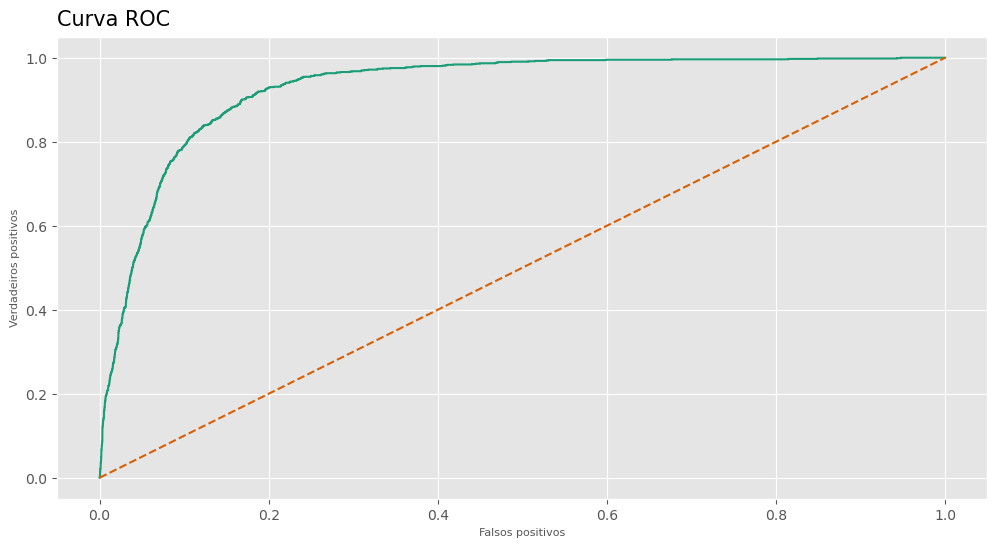

In [68]:
curve = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize = (12, 6))
plt.plot(curve[0], curve[1])
plt.plot([0,1], [0,1], '--')
ax.set_title("Curva ROC", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Falsos positivos", fontsize = 8)
ax.set_ylabel("Verdadeiros positivos", fontsize = 8)
plt.show()